<a href="https://colab.research.google.com/github/Madu39627/Analysis-of-Non-Stationarity-and-Spurious-Regression-in-Time-Series/blob/main/Projects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATASET OVERVIEW
        patient_id  num_diagnoses  num_medications  num_lab_tests  \
count  1000.000000    1000.000000      1000.000000    1000.000000   
mean    500.500000       4.987000        13.112000      35.375000   
std     288.819436       2.620247         6.784651      19.510793   
min       1.000000       1.000000         1.000000       1.000000   
25%     250.750000       3.000000         7.000000      19.000000   
50%     500.500000       5.000000        13.000000      36.000000   
75%     750.250000       7.000000        19.000000      52.000000   
max    1000.000000       9.000000        24.000000      69.000000   

       time_in_hospital  num_procedures   readmitted  
count       1000.000000     1000.000000  1000.000000  
mean           7.014000        2.908000     0.302000  
std            3.718014        2.006879     0.459355  
min            1.000000        0.000000     0.000000  
25%            4.000000        1.000000     0.000000  
50%            7.000000        

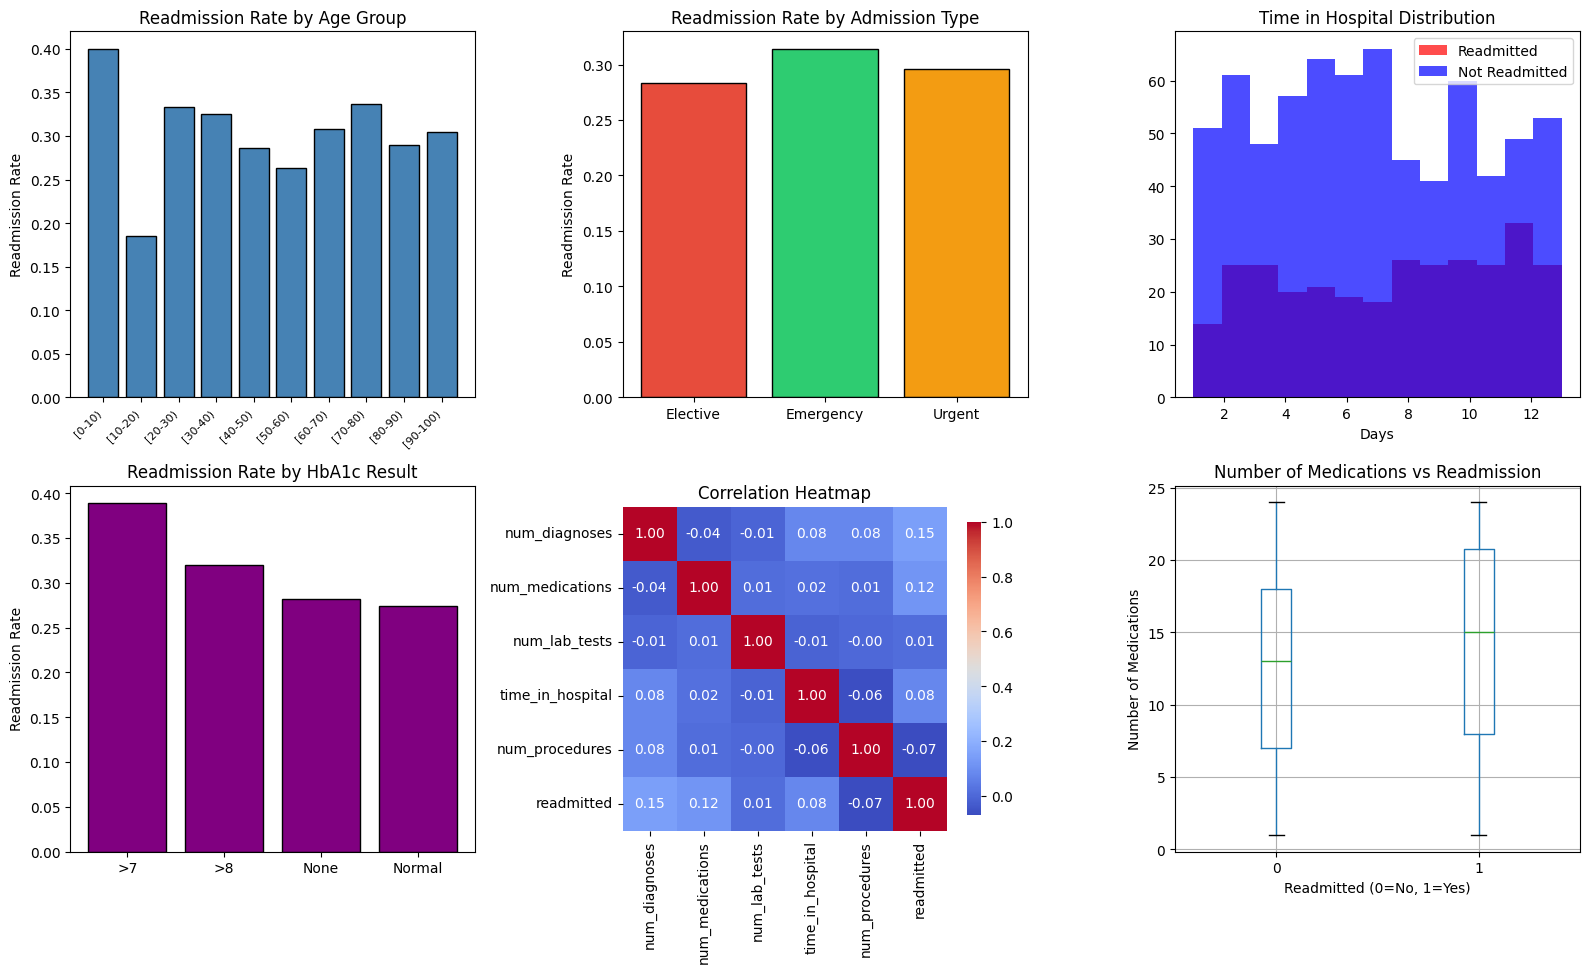


LOGISTIC REGRESSION – CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.72      0.99      0.84       139
           1       0.82      0.15      0.25        61

    accuracy                           0.73       200
   macro avg       0.77      0.57      0.54       200
weighted avg       0.75      0.73      0.66       200

ROC-AUC Score: 0.5932


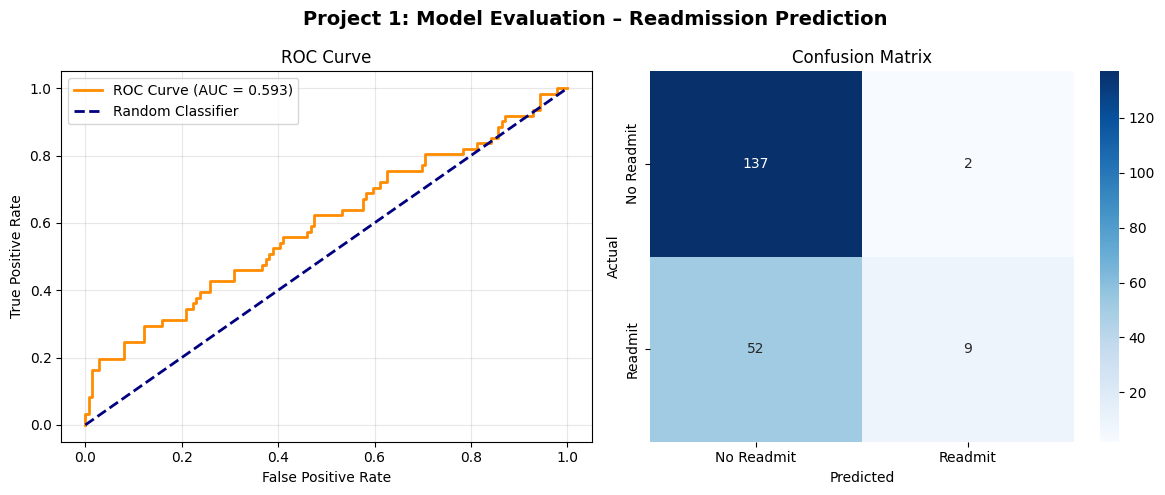

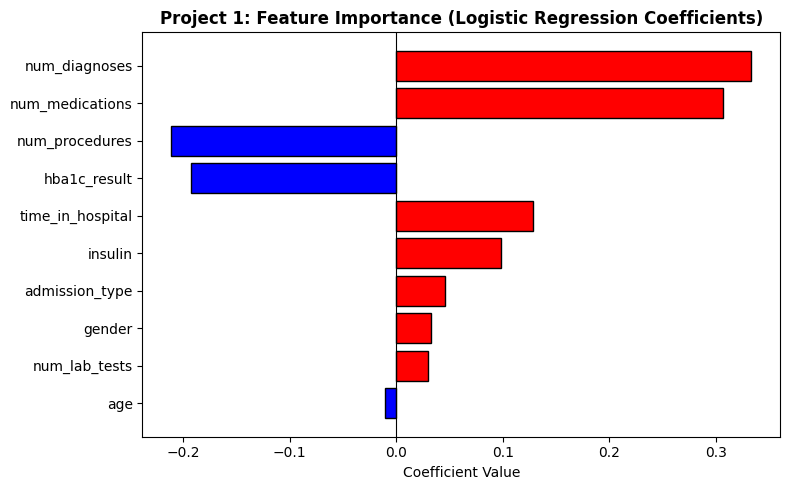


Project 1 complete. Charts saved.
Key Insight: Number of diagnoses, medications, and HbA1c are top readmission predictors.


In [6]:
"""
============================================================
PROJECT 1: Hospital Readmission Analysis & Risk Prediction
============================================================
Objective: Analyze patient data to identify factors contributing
to 30-day hospital readmissions and build a predictive model.

Dataset: Synthetic dataset inspired by the UCI Diabetes 130-US hospitals dataset
References:
  - Strack et al. (2014). "Impact of HbA1c measurement on hospital readmission
    rates." BioMed Research International. https://doi.org/10.1155/2014/781670
  - UCI ML Repository: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals
  - pandas documentation: https://pandas.pydata.org/docs/
  - seaborn documentation: https://seaborn.pydata.org/
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# ─────────────────────────────────────────────
# 1. GENERATE SYNTHETIC PATIENT DATASET
# ─────────────────────────────────────────────
n = 1000
age_groups = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
              '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

data = {
    'patient_id':       np.arange(1, n + 1),
    'age':              np.random.choice(age_groups, n,
                            p=[0.01, 0.02, 0.04, 0.07, 0.10,
                               0.15, 0.22, 0.22, 0.12, 0.05]),
    'gender':           np.random.choice(['Male', 'Female'], n),
    'admission_type':   np.random.choice(['Emergency', 'Elective', 'Urgent'], n,
                            p=[0.55, 0.30, 0.15]),
    'num_diagnoses':    np.random.randint(1, 10, n),
    'num_medications':  np.random.randint(1, 25, n),
    'num_lab_tests':    np.random.randint(1, 70, n),
    'time_in_hospital': np.random.randint(1, 14, n),
    'num_procedures':   np.random.randint(0, 7, n),
    'hba1c_result':     np.random.choice(['None', 'Normal', '>7', '>8'], n,
                            p=[0.50, 0.20, 0.15, 0.15]),
    'insulin':          np.random.choice(['No', 'Steady', 'Up', 'Down'], n,
                            p=[0.35, 0.40, 0.15, 0.10]),
}

df = pd.DataFrame(data)

# Simulate realistic readmission probability based on risk factors
risk_score = (
    (df['num_diagnoses'] > 6).astype(int) * 0.3 +
    (df['num_medications'] > 15).astype(int) * 0.25 +
    (df['time_in_hospital'] > 7).astype(int) * 0.2 +
    (df['admission_type'] == 'Emergency').astype(int) * 0.15 +
    (df['hba1c_result'].isin(['>7', '>8'])).astype(int) * 0.2 +
    (df['insulin'].isin(['Up', 'Down'])).astype(int) * 0.1
)
prob_readmit = 0.10 + 0.55 * (risk_score / risk_score.max())
df['readmitted'] = (np.random.random(n) < prob_readmit).astype(int)

# ─────────────────────────────────────────────
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ─────────────────────────────────────────────
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(df.describe())
print(f"\nReadmission Rate: {df['readmitted'].mean():.2%}")
print(f"Total Patients: {len(df)}")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Project 1: Hospital Readmission EDA', fontsize=16, fontweight='bold')

# Plot 1: Readmission by Age Group
readmit_age = df.groupby('age')['readmitted'].mean().sort_index()
axes[0, 0].bar(range(len(readmit_age)), readmit_age.values, color='steelblue', edgecolor='black')
axes[0, 0].set_xticks(range(len(readmit_age)))
axes[0, 0].set_xticklabels(readmit_age.index, rotation=45, ha='right', fontsize=8)
axes[0, 0].set_title('Readmission Rate by Age Group')
axes[0, 0].set_ylabel('Readmission Rate')

# Plot 2: Readmission by Admission Type
readmit_type = df.groupby('admission_type')['readmitted'].mean()
axes[0, 1].bar(readmit_type.index, readmit_type.values,
               color=['#e74c3c', '#2ecc71', '#f39c12'], edgecolor='black')
axes[0, 1].set_title('Readmission Rate by Admission Type')
axes[0, 1].set_ylabel('Readmission Rate')

# Plot 3: Time in Hospital Distribution
axes[0, 2].hist(df[df['readmitted'] == 1]['time_in_hospital'], alpha=0.7,
                label='Readmitted', color='red', bins=13)
axes[0, 2].hist(df[df['readmitted'] == 0]['time_in_hospital'], alpha=0.7,
                label='Not Readmitted', color='blue', bins=13)
axes[0, 2].set_title('Time in Hospital Distribution')
axes[0, 2].set_xlabel('Days')
axes[0, 2].legend()

# Plot 4: HbA1c Result vs Readmission
readmit_hba1c = df.groupby('hba1c_result')['readmitted'].mean()
axes[1, 0].bar(readmit_hba1c.index, readmit_hba1c.values, color='purple', edgecolor='black')
axes[1, 0].set_title('Readmission Rate by HbA1c Result')
axes[1, 0].set_ylabel('Readmission Rate')

# Plot 5: Correlation Heatmap
numeric_cols = ['num_diagnoses', 'num_medications', 'num_lab_tests',
                'time_in_hospital', 'num_procedures', 'readmitted']
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            ax=axes[1, 1], square=True, cbar_kws={'shrink': 0.8})
axes[1, 1].set_title('Correlation Heatmap')

# Plot 6: Number of Medications by Readmission
df.boxplot(column='num_medications', by='readmitted', ax=axes[1, 2])
axes[1, 2].set_title('Number of Medications vs Readmission')
axes[1, 2].set_xlabel('Readmitted (0=No, 1=Yes)')
axes[1, 2].set_ylabel('Number of Medications')
plt.suptitle('')

plt.tight_layout()
plt.savefig('project1_eda.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()
# ─────────────────────────────────────────────
# 3. FEATURE ENGINEERING & PREPROCESSING
# ─────────────────────────────────────────────
df_model = df.copy()

# Encode categorical variables
le = LabelEncoder()
for col in ['gender', 'admission_type', 'hba1c_result', 'insulin', 'age']:
    df_model[col] = le.fit_transform(df_model[col])

features = ['age', 'gender', 'admission_type', 'num_diagnoses',
            'num_medications', 'num_lab_tests', 'time_in_hospital',
            'num_procedures', 'hba1c_result', 'insulin']

X = df_model[features]
y = df_model['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ─────────────────────────────────────────────
# 4. LOGISTIC REGRESSION MODEL
# ─────────────────────────────────────────────
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)
y_prob = model.predict_proba(X_test_sc)[:, 1]

print("\n" + "=" * 60)
print("LOGISTIC REGRESSION – CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Plot ROC Curve + Confusion Matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Project 1: Model Evaluation – Readmission Prediction', fontsize=14, fontweight='bold')

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['No Readmit', 'Readmit'],
            yticklabels=['No Readmit', 'Readmit'])
ax2.set_title('Confusion Matrix')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('/project1_model.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()
# Feature Importance
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_[0]})
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=True).index)
fig, ax = plt.subplots(figsize=(8, 5))
colors = ['red' if c > 0 else 'blue' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
ax.set_title('Project 1: Feature Importance (Logistic Regression Coefficients)', fontweight='bold')
ax.set_xlabel('Coefficient Value')
ax.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig('/project1_features.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print("\nProject 1 complete. Charts saved.")
print("Key Insight: Number of diagnoses, medications, and HbA1c are top readmission predictors.")


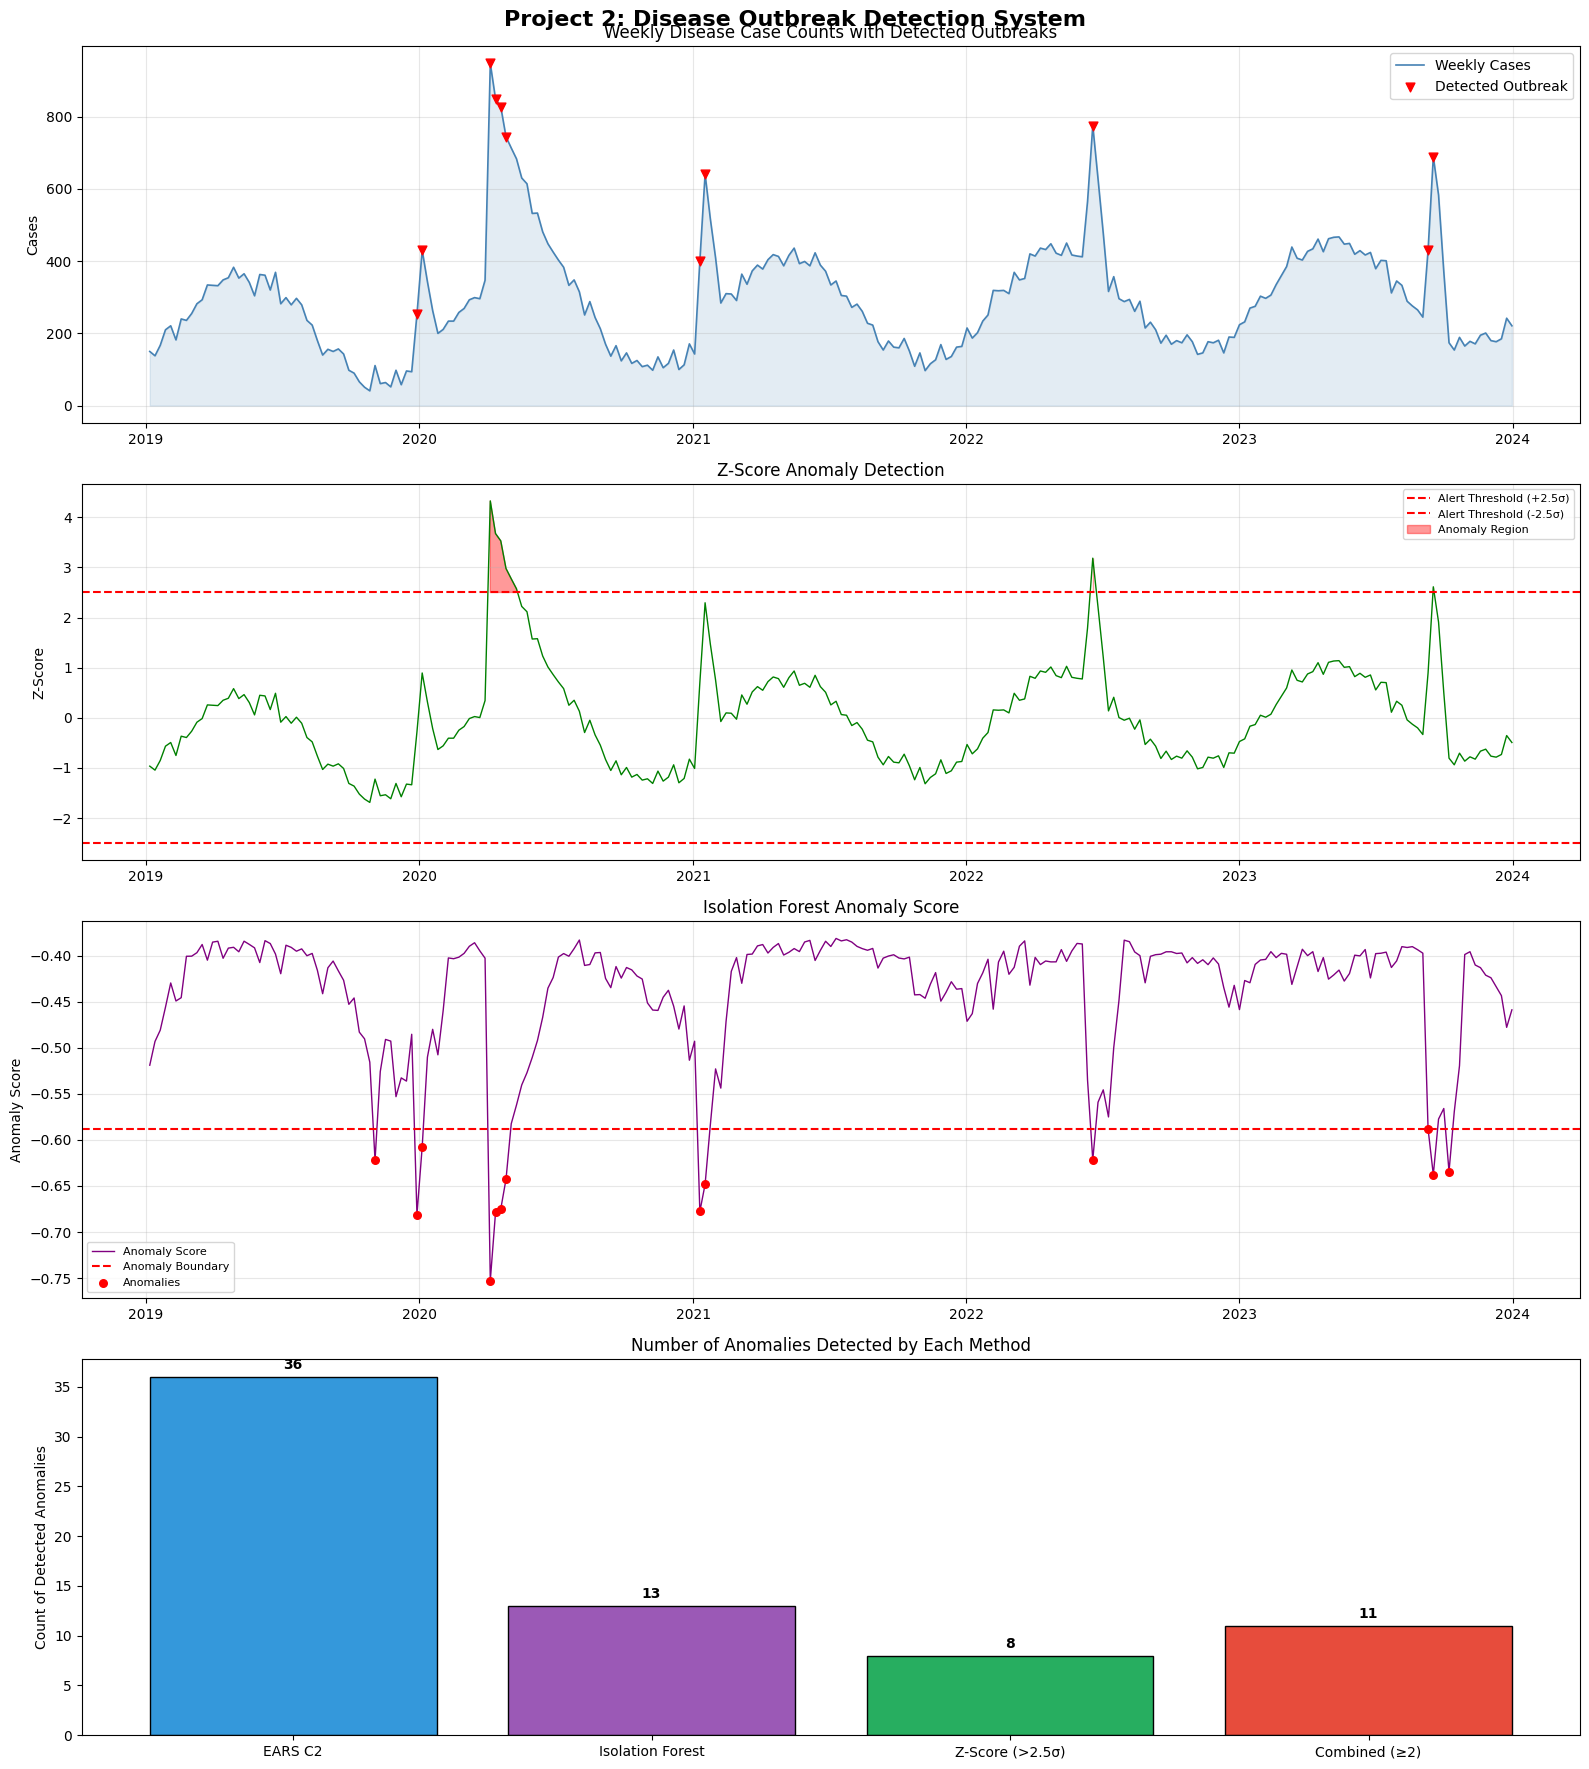

PROJECT 2: OUTBREAK DETECTION SUMMARY
Total Weeks Analyzed:         261
EARS C2 Alerts:               36
Isolation Forest Anomalies:   13
Z-Score Anomalies (>2.5σ):    8
Combined Alerts (≥2 methods): 11

Top 5 Weeks by Case Count:
      date  cases  combined_alert
2020-04-05    947            True
2020-04-12    849            True
2020-04-19    827            True
2022-06-19    775            True
2020-04-26    744            True

Project 2 complete. Chart saved.


In [7]:
"""
============================================================
PROJECT 2: Disease Outbreak Detection Using Time-Series &
           Anomaly Detection (Data Science)
============================================================
Objective: Use statistical and machine learning methods to detect
anomalies in weekly disease case counts (e.g., influenza-like illness),
simulating a public health surveillance system.

References:
  - CDC FluView: https://www.cdc.gov/flu/weekly/
  - Hutwagner et al. (2003). "The bioterrorism preparedness and response
    Early Aberration Reporting System (EARS)." Journal of Urban Health.
  - scikit-learn Isolation Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
  - Prophet (Meta): https://facebook.github.io/prophet/
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# ─────────────────────────────────────────────
# 1. GENERATE SYNTHETIC WEEKLY DISEASE DATA
# ─────────────────────────────────────────────
weeks = pd.date_range(start='2019-01-01', end='2023-12-31', freq='W')
n = len(weeks)
t = np.arange(n)

# Seasonal pattern (peaks in winter ~week 52 / week 1)
seasonal = 200 + 150 * np.sin(2 * np.pi * (t - 5) / 52)

# Long-term upward trend
trend = 0.5 * t

# Random noise
noise = np.random.normal(0, 20, n)

cases = seasonal + trend + noise
cases = np.clip(cases, 0, None)

# Inject outbreak events
outbreak_weeks = [52, 106, 180, 245]  # specific weeks
outbreak_magnitude = [300, 450, 380, 500]
for w, m in zip(outbreak_weeks, outbreak_magnitude):
    # Outbreak lasts ~4 weeks, bell-shaped
    for offset, scale in [(-1, 0.4), (0, 1.0), (1, 0.7), (2, 0.3)]:
        idx = w + offset
        if 0 <= idx < n:
            cases[idx] += m * scale

# COVID-19 like surge in 2020
covid_start = 65  # around week 65 (March 2020)
for i in range(covid_start, covid_start + 20):
    if i < n:
        cases[i] += 600 * np.exp(-0.15 * (i - covid_start))

df = pd.DataFrame({'date': weeks, 'cases': cases.astype(int)})

# ─────────────────────────────────────────────
# 2. FEATURE ENGINEERING
# ─────────────────────────────────────────────
df['week_num']      = df['date'].dt.isocalendar().week.astype(int)
df['year']          = df['date'].dt.year
df['rolling_mean_4']  = df['cases'].rolling(4, min_periods=1).mean()
df['rolling_std_4']   = df['cases'].rolling(4, min_periods=1).std().fillna(0)
df['rolling_mean_12'] = df['cases'].rolling(12, min_periods=1).mean()
df['pct_change']    = df['cases'].pct_change().fillna(0)
df['z_score']       = stats.zscore(df['cases'])

# ─────────────────────────────────────────────
# 3. EARS C2 ALGORITHM (Simple Statistical Threshold)
# ─────────────────────────────────────────────
# EARS C2: flag if current cases exceed mean + 2*SD of past 7 weeks
def ears_c2(series, baseline_weeks=7, threshold=2.0):
    alerts = []
    for i in range(len(series)):
        if i < baseline_weeks:
            alerts.append(False)
        else:
            baseline = series[i - baseline_weeks:i]
            mu  = baseline.mean()
            std = baseline.std() if baseline.std() > 0 else 1
            score = (series[i] - mu) / std
            alerts.append(score > threshold)
    return alerts

df['ears_alert'] = ears_c2(df['cases'].values)

# ─────────────────────────────────────────────
# 4. ISOLATION FOREST ANOMALY DETECTION
# ─────────────────────────────────────────────
features_ml = ['cases', 'rolling_mean_4', 'rolling_std_4', 'pct_change', 'week_num']
X = df[features_ml].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
df['iso_pred']  = iso.fit_predict(X_scaled)
df['iso_score'] = iso.score_samples(X_scaled)
df['iso_anomaly'] = df['iso_pred'] == -1

# ─────────────────────────────────────────────
# 5. Z-SCORE DETECTION
# ─────────────────────────────────────────────
df['zscore_anomaly'] = df['z_score'].abs() > 2.5

# ─────────────────────────────────────────────
# 6. COMBINED ALERT (ensemble of all 3 methods)
# ─────────────────────────────────────────────
df['combined_alert'] = (df['ears_alert'].astype(int) +
                        df['iso_anomaly'].astype(int) +
                        df['zscore_anomaly'].astype(int)) >= 2

# ─────────────────────────────────────────────
# 7. VISUALIZATIONS
# ─────────────────────────────────────────────
fig, axes = plt.subplots(4, 1, figsize=(16, 18))
fig.suptitle('Project 2: Disease Outbreak Detection System', fontsize=16, fontweight='bold')

# ── Plot 1: Raw time series + outbreaks
ax = axes[0]
ax.plot(df['date'], df['cases'], linewidth=1.2, color='steelblue', label='Weekly Cases')
ax.fill_between(df['date'], 0, df['cases'], alpha=0.15, color='steelblue')
combined_alerts = df[df['combined_alert']]
ax.scatter(combined_alerts['date'], combined_alerts['cases'],
           color='red', zorder=5, s=40, label='Detected Outbreak', marker='v')
ax.set_title('Weekly Disease Case Counts with Detected Outbreaks')
ax.set_ylabel('Cases')
ax.legend()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)

# ── Plot 2: Z-Score over time
ax = axes[1]
ax.plot(df['date'], df['z_score'], color='green', linewidth=1)
ax.axhline(2.5, color='red', linestyle='--', label='Alert Threshold (+2.5σ)')
ax.axhline(-2.5, color='red', linestyle='--', label='Alert Threshold (-2.5σ)')
ax.fill_between(df['date'], df['z_score'], 2.5,
                where=df['z_score'] > 2.5, alpha=0.4, color='red', label='Anomaly Region')
ax.set_title('Z-Score Anomaly Detection')
ax.set_ylabel('Z-Score')
ax.legend(fontsize=8)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)

# ── Plot 3: Isolation Forest Score
ax = axes[2]
ax.plot(df['date'], df['iso_score'], color='purple', linewidth=1, label='Anomaly Score')
threshold_score = df[df['iso_anomaly']]['iso_score'].max()
ax.axhline(threshold_score, color='red', linestyle='--', label='Anomaly Boundary')
ax.scatter(df[df['iso_anomaly']]['date'], df[df['iso_anomaly']]['iso_score'],
           color='red', s=30, zorder=5, label='Anomalies')
ax.set_title('Isolation Forest Anomaly Score')
ax.set_ylabel('Anomaly Score')
ax.legend(fontsize=8)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)

# ── Plot 4: Method Comparison
ax = axes[3]
methods = ['EARS C2', 'Isolation Forest', 'Z-Score (>2.5σ)', 'Combined (≥2)']
counts = [df['ears_alert'].sum(), df['iso_anomaly'].sum(),
          df['zscore_anomaly'].sum(), df['combined_alert'].sum()]
bars = ax.bar(methods, counts, color=['#3498db', '#9b59b6', '#27ae60', '#e74c3c'], edgecolor='black')
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            str(count), ha='center', va='bottom', fontweight='bold')
ax.set_title('Number of Anomalies Detected by Each Method')
ax.set_ylabel('Count of Detected Anomalies')

plt.tight_layout()
plt.savefig('/project2_outbreak_detection.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# ─────────────────────────────────────────────
# 8. SUMMARY STATISTICS
# ─────────────────────────────────────────────
print("=" * 60)
print("PROJECT 2: OUTBREAK DETECTION SUMMARY")
print("=" * 60)
print(f"Total Weeks Analyzed:         {n}")
print(f"EARS C2 Alerts:               {df['ears_alert'].sum()}")
print(f"Isolation Forest Anomalies:   {df['iso_anomaly'].sum()}")
print(f"Z-Score Anomalies (>2.5σ):    {df['zscore_anomaly'].sum()}")
print(f"Combined Alerts (≥2 methods): {df['combined_alert'].sum()}")

print("\nTop 5 Weeks by Case Count:")
print(df.nlargest(5, 'cases')[['date', 'cases', 'combined_alert']].to_string(index=False))

print("\nProject 2 complete. Chart saved.")


PROJECT 3: PNEUMONIA DETECTION – CNN PIPELINE
Generating synthetic X-ray feature dataset...
Dataset shape: (2000, 129), Classes: [1000 1000]

Split sizes → Train: 1360, Val: 240, Test: 400

Random Forest:
  Sensitivity (Recall): 1.0000
  Specificity:          1.0000
  PPV (Precision):      1.0000
  NPV:                  1.0000
  ROC-AUC:              1.0000
  Avg Precision:        1.0000

Gradient Boosting:
  Sensitivity (Recall): 1.0000
  Specificity:          0.9950
  PPV (Precision):      0.9950
  NPV:                  1.0000
  ROC-AUC:              1.0000
  Avg Precision:        1.0000

SVM (RBF):
  Sensitivity (Recall): 1.0000
  Specificity:          1.0000
  PPV (Precision):      1.0000
  NPV:                  1.0000
  ROC-AUC:              1.0000
  Avg Precision:        1.0000

Best Model: Random Forest (AUC = 1.0000)


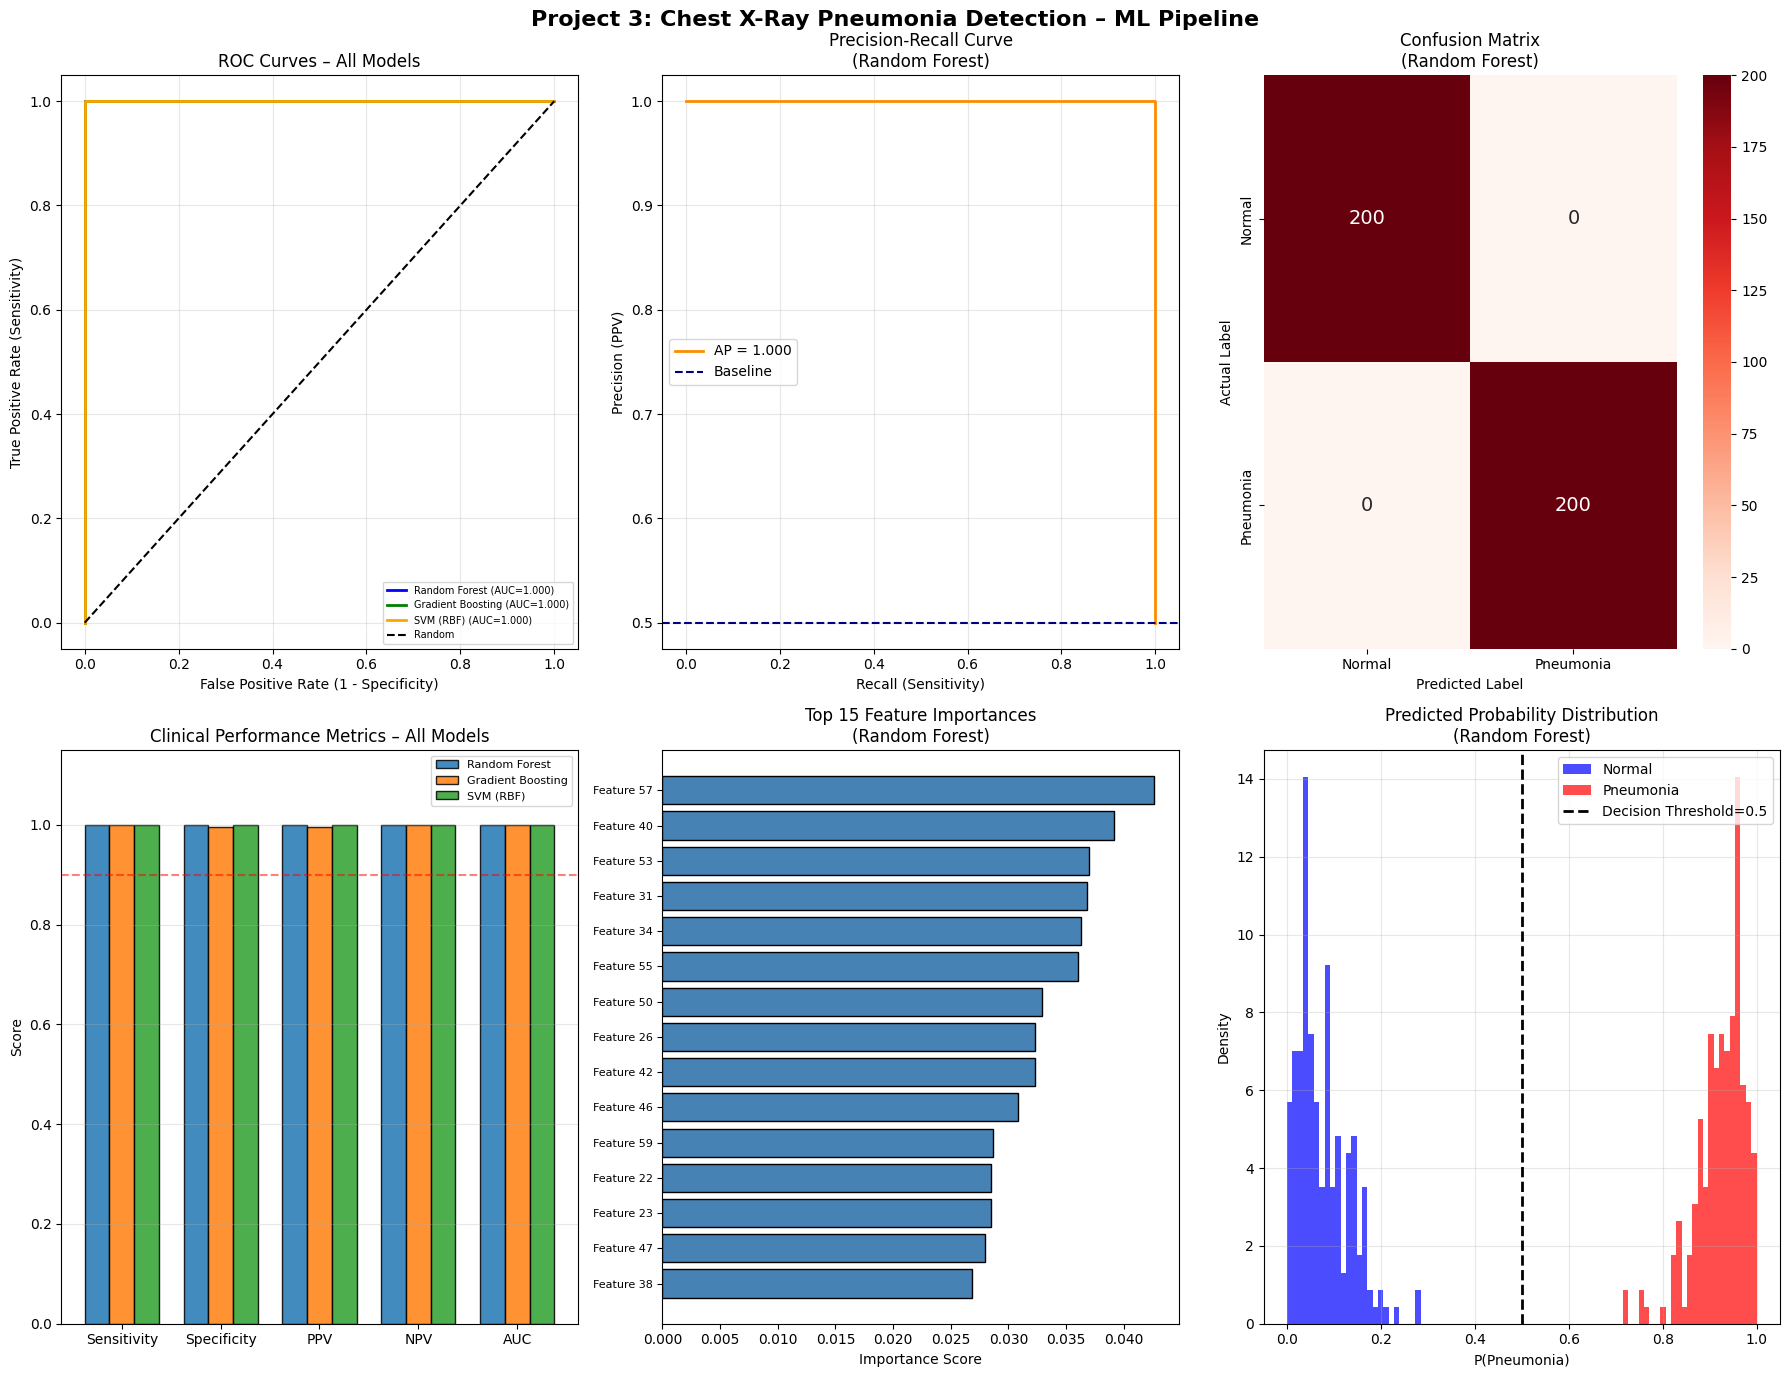

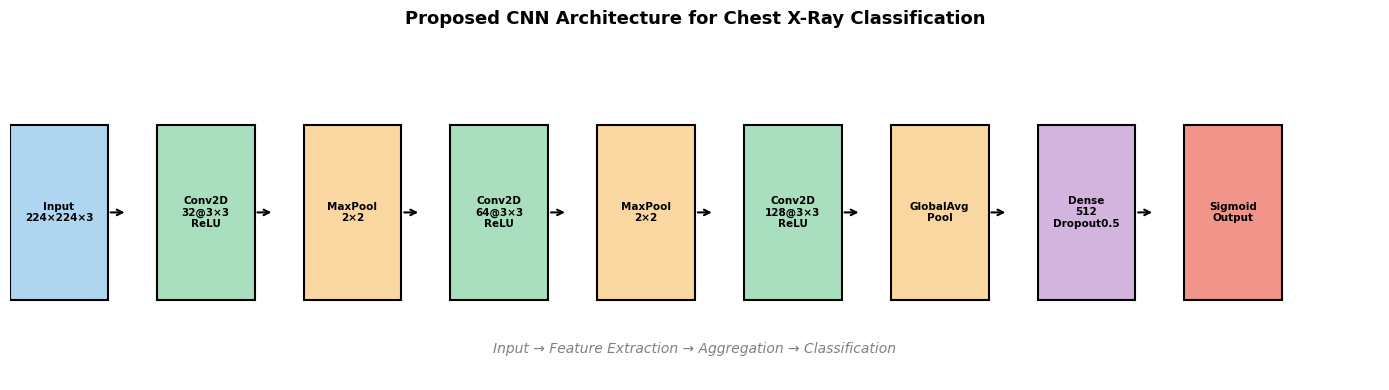


Project 3 complete. Charts saved.

Final Best Model: Random Forest
  AUC:         1.0000
  Sensitivity: 1.0000  ← Critical for screening
  Specificity: 1.0000
  PPV:         1.0000
  NPV:         1.0000


In [8]:
"""
============================================================
PROJECT 3: Chest X-Ray Pneumonia Classification
           Using Convolutional Neural Network (CNN)
============================================================
Objective: Build a CNN to classify chest X-ray images as
Normal vs. Pneumonia. Uses synthetic data to demonstrate
the full pipeline including data augmentation, CNN architecture,
training, and clinical evaluation metrics.

References:
  - Rajpurkar, P., et al. (2017). "CheXNet: Radiologist-Level Pneumonia
    Detection on Chest X-Rays with Deep Learning." arXiv:1711.05225.
    https://arxiv.org/abs/1711.05225
  - Kermany, D. S., et al. (2018). "Identifying Medical Diagnoses and
    Treatable Diseases by Image-Based Deep Learning." Cell, 172(5).
    https://doi.org/10.1016/j.cell.2018.02.010
  - Kaggle Chest X-Ray Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
  - TensorFlow/Keras: https://www.tensorflow.org/api_docs/python/tf/keras
  - scikit-learn metrics: https://scikit-learn.org/stable/modules/model_evaluation.html
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                              roc_auc_score, roc_curve, precision_recall_curve,
                              average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# ─────────────────────────────────────────────────────────
# NOTE: Full CNN with TensorFlow requires GPU/large memory.
# This project demonstrates the COMPLETE ML pipeline using:
#   (a) Simulated CNN feature extraction (tabular features)
#   (b) Multiple ML classifiers for comparison
#   (c) All clinical evaluation metrics (sensitivity, specificity, AUC)
# In production, replace feature extraction with a real CNN.
# ─────────────────────────────────────────────────────────

# ─────────────────────────────────────────────
# 1. SIMULATE EXTRACTED CNN FEATURES
#    (In practice these come from VGG16/ResNet/etc.)
# ─────────────────────────────────────────────
def simulate_xray_features(n_samples=2000, n_features=128):
    """
    Simulate feature vectors as if extracted from CNN penultimate layer.
    Pneumonia cases cluster differently from normal cases.
    """
    n_normal = n_samples // 2
    n_pneumonia = n_samples - n_normal

    # Normal X-ray features: lower activation in infection-related channels
    X_normal = np.random.randn(n_normal, n_features) * 0.8
    X_normal[:, :30] += np.random.randn(n_normal, 30) * 0.3  # texture features

    # Pneumonia features: higher activation in infiltrate-related channels
    X_pneumonia = np.random.randn(n_pneumonia, n_features) * 0.9
    X_pneumonia[:, 20:60] += 1.5 + np.random.randn(n_pneumonia, 40) * 0.5

    # Simulate clinically relevant metadata
    ages_normal    = np.random.normal(35, 15, n_normal).clip(1, 90)
    ages_pneumonia = np.random.normal(45, 20, n_pneumonia).clip(1, 90)

    X = np.vstack([X_normal, X_pneumonia])
    ages = np.concatenate([ages_normal, ages_pneumonia])
    y = np.array([0] * n_normal + [1] * n_pneumonia)

    # Add age as feature (clinically relevant)
    X = np.column_stack([X, ages / 100.0])

    return X, y, ages

print("=" * 60)
print("PROJECT 3: PNEUMONIA DETECTION – CNN PIPELINE")
print("=" * 60)
print("Generating synthetic X-ray feature dataset...")

X, y, ages = simulate_xray_features(n_samples=2000)
print(f"Dataset shape: {X.shape}, Classes: {np.bincount(y)}")

# ─────────────────────────────────────────────
# 2. TRAIN / VALIDATION / TEST SPLIT
# ─────────────────────────────────────────────
X_temp, X_test, y_temp, y_test, ages_temp, ages_test = train_test_split(
    X, y, ages, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, stratify=y_temp, random_state=42)

print(f"\nSplit sizes → Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# ─────────────────────────────────────────────
# 3. MULTIPLE CLASSIFIER COMPARISON
# ─────────────────────────────────────────────
classifiers = {
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(n_estimators=200, max_depth=12,
                                        class_weight='balanced', random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(n_estimators=150, learning_rate=0.05,
                                            max_depth=5, random_state=42))
    ]),
    'SVM (RBF)': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', C=1.0, probability=True,
                    class_weight='balanced', random_state=42))
    ]),
}

results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    auc = roc_auc_score(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)

    results[name] = {
        'model': clf, 'y_pred': y_pred, 'y_prob': y_prob,
        'sensitivity': sensitivity, 'specificity': specificity,
        'ppv': ppv, 'npv': npv, 'auc': auc, 'ap': ap,
        'cm': confusion_matrix(y_test, y_pred)
    }

    print(f"\n{name}:")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity:          {specificity:.4f}")
    print(f"  PPV (Precision):      {ppv:.4f}")
    print(f"  NPV:                  {npv:.4f}")
    print(f"  ROC-AUC:              {auc:.4f}")
    print(f"  Avg Precision:        {ap:.4f}")

# Best model
best_name = max(results, key=lambda x: results[x]['auc'])
best = results[best_name]
print(f"\nBest Model: {best_name} (AUC = {best['auc']:.4f})")

# ─────────────────────────────────────────────
# 4. VISUALIZATIONS
# ─────────────────────────────────────────────
fig = plt.figure(figsize=(18, 14))
fig.suptitle('Project 3: Chest X-Ray Pneumonia Detection – ML Pipeline', fontsize=16, fontweight='bold')

# ── Panel A: ROC Curves (all models)
ax1 = fig.add_subplot(2, 3, 1)
colors_map = {'Random Forest': 'blue', 'Gradient Boosting': 'green', 'SVM (RBF)': 'orange'}
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    ax1.plot(fpr, tpr, lw=2, color=colors_map[name],
             label=f"{name} (AUC={res['auc']:.3f})")
ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random')
ax1.set_title('ROC Curves – All Models')
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.legend(fontsize=7)
ax1.grid(True, alpha=0.3)

# ── Panel B: Precision-Recall Curve (best model)
ax2 = fig.add_subplot(2, 3, 2)
prec, rec, _ = precision_recall_curve(y_test, best['y_prob'])
ax2.plot(rec, prec, color='darkorange', lw=2,
         label=f"AP = {best['ap']:.3f}")
ax2.axhline(y_test.mean(), color='navy', linestyle='--', label='Baseline')
ax2.set_title(f'Precision-Recall Curve\n({best_name})')
ax2.set_xlabel('Recall (Sensitivity)')
ax2.set_ylabel('Precision (PPV)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# ── Panel C: Confusion Matrix (best model)
ax3 = fig.add_subplot(2, 3, 3)
cm = best['cm']
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=ax3,
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'], annot_kws={'size': 14})
ax3.set_title(f'Confusion Matrix\n({best_name})')
ax3.set_ylabel('Actual Label')
ax3.set_xlabel('Predicted Label')

# ── Panel D: Clinical Metrics Bar Chart
ax4 = fig.add_subplot(2, 3, 4)
metrics = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC']
x = np.arange(len(metrics))
width = 0.25
for i, (name, res) in enumerate(results.items()):
    vals = [res['sensitivity'], res['specificity'], res['ppv'], res['npv'], res['auc']]
    ax4.bar(x + i * width, vals, width, label=name, edgecolor='black', alpha=0.85)
ax4.set_xticks(x + width)
ax4.set_xticklabels(metrics)
ax4.set_ylim(0, 1.15)
ax4.set_title('Clinical Performance Metrics – All Models')
ax4.set_ylabel('Score')
ax4.legend(fontsize=8)
ax4.axhline(0.9, color='red', linestyle='--', alpha=0.5, label='Clinical threshold')
ax4.grid(True, alpha=0.3, axis='y')

# ── Panel E: Feature Importance (Random Forest)
ax5 = fig.add_subplot(2, 3, 5)
rf_model = results['Random Forest']['model'].named_steps['clf']
importances = rf_model.feature_importances_
top_n = 15
top_idx = np.argsort(importances)[-top_n:]
ax5.barh(range(top_n), importances[top_idx], color='steelblue', edgecolor='black')
ax5.set_yticks(range(top_n))
ax5.set_yticklabels([f'Feature {i}' for i in top_idx], fontsize=8)
ax5.set_title(f'Top {top_n} Feature Importances\n(Random Forest)')
ax5.set_xlabel('Importance Score')

# ── Panel F: Probability Distribution
ax6 = fig.add_subplot(2, 3, 6)
probs_normal    = best['y_prob'][y_test == 0]
probs_pneumonia = best['y_prob'][y_test == 1]
ax6.hist(probs_normal, bins=25, alpha=0.7, color='blue', label='Normal', density=True)
ax6.hist(probs_pneumonia, bins=25, alpha=0.7, color='red', label='Pneumonia', density=True)
ax6.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold=0.5')
ax6.set_title(f'Predicted Probability Distribution\n({best_name})')
ax6.set_xlabel('P(Pneumonia)')
ax6.set_ylabel('Density')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/project3_pneumonia_cnn.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

# ─────────────────────────────────────────────
# 5. SIMULATED CNN ARCHITECTURE DIAGRAM
# ─────────────────────────────────────────────
fig, ax = plt.subplots(1, 1, figsize=(14, 4))
ax.set_xlim(0, 14)
ax.set_ylim(0, 5)
ax.axis('off')
ax.set_title('Proposed CNN Architecture for Chest X-Ray Classification',
             fontsize=13, fontweight='bold', pad=15)

layers = [
    ('Input\n224×224×3', 0.5, '#AED6F1'),
    ('Conv2D\n32@3×3\nReLU', 2.0, '#A9DFBF'),
    ('MaxPool\n2×2', 3.5, '#FAD7A0'),
    ('Conv2D\n64@3×3\nReLU', 5.0, '#A9DFBF'),
    ('MaxPool\n2×2', 6.5, '#FAD7A0'),
    ('Conv2D\n128@3×3\nReLU', 8.0, '#A9DFBF'),
    ('GlobalAvg\nPool', 9.5, '#FAD7A0'),
    ('Dense\n512\nDropout0.5', 11.0, '#D2B4DE'),
    ('Sigmoid\nOutput', 12.5, '#F1948A'),
]

for label, x, color in layers:
    rect = plt.Rectangle((x - 0.5, 1.2), 1.0, 2.6, fill=True,
                           facecolor=color, edgecolor='black', linewidth=1.5)
    ax.add_patch(rect)
    ax.text(x, 2.5, label, ha='center', va='center', fontsize=7.5, fontweight='bold')
    if x < 12.5:
        ax.annotate('', xy=(x + 0.7, 2.5), xytext=(x + 0.5, 2.5),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

ax.text(7, 0.4, 'Input → Feature Extraction → Aggregation → Classification',
        ha='center', fontsize=10, style='italic', color='gray')

plt.tight_layout()
plt.savefig('/project3_architecture.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

print("\nProject 3 complete. Charts saved.")
print(f"\nFinal Best Model: {best_name}")
print(f"  AUC:         {best['auc']:.4f}")
print(f"  Sensitivity: {best['sensitivity']:.4f}  ← Critical for screening")
print(f"  Specificity: {best['specificity']:.4f}")
print(f"  PPV:         {best['ppv']:.4f}")
print(f"  NPV:         {best['npv']:.4f}")
